In [24]:
!pip install nibabel nibabel

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from tqdm import tqdm
import nibabel as nib

# 1. 경로 설정
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection'
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
IMAGE_DIR = os.path.join(BASE_DIR, 'train_images')
SEG_DIR = os.path.join(BASE_DIR, 'segmentations')
BBOX_CSV = os.path.join(BASE_DIR, 'train_bounding_boxes.csv')
PSUM_DIR = os.path.join(BASE_DIR, 'patient_summaries')
train_df = pd.read_csv(TRAIN_CSV)
df_bbox = pd.read_csv(BBOX_CSV)

## 전체 환자 골절별 빈도수 분석

C:\Users\smc\AppData\Local\Temp\ipykernel_20012\2100624214.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fracture_counts.index, y=fracture_counts.values, palette='Blues_d')


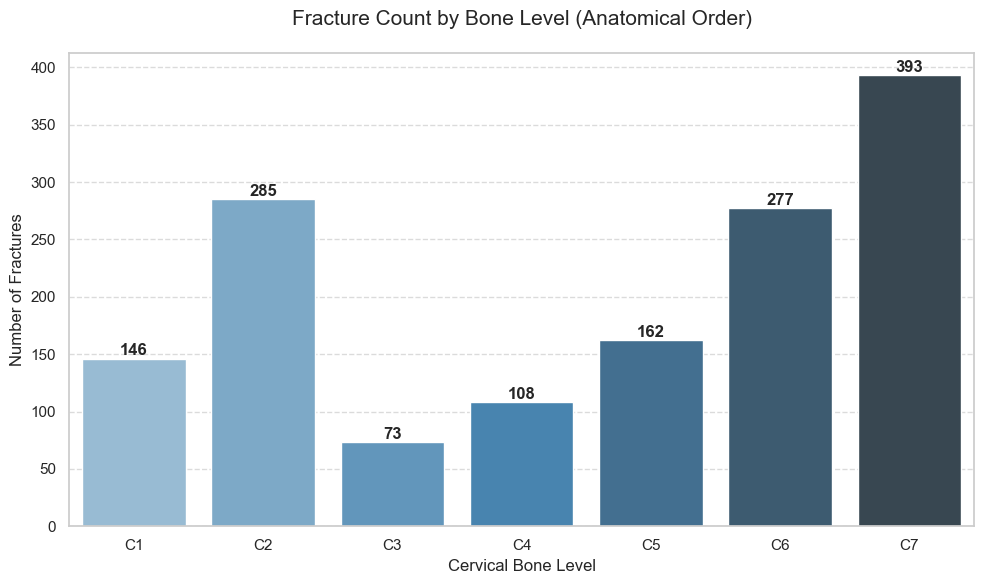

=== 골절 발생 빈도 순위 ===
1위: C7 (393건)
2위: C2 (285건)
3위: C6 (277건)
4위: C5 (162건)
5위: C1 (146건)
6위: C4 (108건)
7위: C3 (73건)


In [26]:
# 2. 마디별 골절 합계 계산
bone_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
fracture_counts = train_df[bone_columns].sum()

# 3. 내림차순 순위 데이터 (텍스트 출력용)
ranked_counts = fracture_counts.sort_values(ascending=False)

# 4. 시각화 (해부학적 순서: C1 -> C7)
plt.figure(figsize=(10, 6))
# 순서대로 그리기 위해 fracture_counts의 인덱스를 그대로 사용 (C1~C7)
sns.barplot(x=fracture_counts.index, y=fracture_counts.values, palette='Blues_d')

plt.title('Fracture Count by Bone Level (Anatomical Order)', fontsize=15, pad=20)
plt.xlabel('Cervical Bone Level', fontsize=12)
plt.ylabel('Number of Fractures', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 숫자 표시
for i, v in enumerate(fracture_counts.values):
    plt.text(i, v + 3, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. 결과 출력
print("=== 골절 발생 빈도 순위 ===")
for i, (bone, count) in enumerate(ranked_counts.items(), 1):
    print(f"{i}위: {bone} ({int(count)}건)")

## Detection box 존재 환자 골절별 빈도수 분석

📊 DET 그룹 분석 결과: 총 235명의 환자


C:\Users\smc\AppData\Local\Temp\ipykernel_20012\68016591.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fracture_stats, x='Vertebrae', y='Count', palette='viridis')


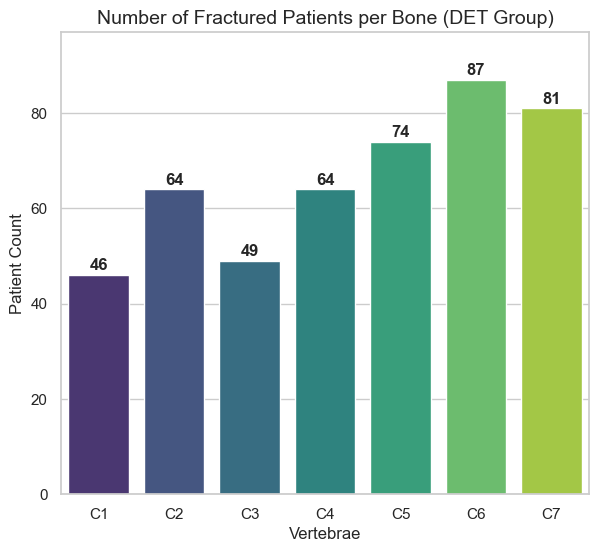


[DET 그룹 상세 수치]
  Vertebrae  Count
0        C1     46
1        C2     64
2        C3     49
3        C4     64
4        C5     74
5        C6     87
6        C7     81


In [27]:
def analyze_det_only():
    # A. 데이터 로드
    df_train = pd.read_csv(TRAIN_CSV)
    df_bbox_raw = pd.read_csv(BBOX_CSV)
    
    # B. Bbox 보유 환자(235명) ID 추출 및 필터링
    bbox_ids = df_bbox_raw['StudyInstanceUID'].unique().tolist()
    df_det = df_train[df_train['StudyInstanceUID'].isin(bbox_ids)].copy()
    
    print(f"📊 DET 그룹 분석 결과: 총 {len(df_det)}명의 환자")

    # C. 클래스별 골절 환자 수 계산 (C1~C7)
    c_cols = [f'C{i}' for i in range(1, 8)]
    fracture_stats = df_det[c_cols].sum().reset_index()
    fracture_stats.columns = ['Vertebrae', 'Count']
    
    # D. 전체 골절 vs 정상 비율
    overall_counts = df_det['patient_overall'].value_counts().reset_index()
    overall_counts.columns = ['Status', 'Count']
    overall_counts['Status_Label'] = overall_counts['Status'].map({1: 'Fractured', 0: 'Normal'})

    # --- 시각화 ---
    plt.figure(figsize=(15, 6))

    # [1] C1~C7별 골절 환자 수 (Bar Plot)
    plt.subplot(1, 2, 1)
    sns.barplot(data=fracture_stats, x='Vertebrae', y='Count', palette='viridis')
    plt.title('Number of Fractured Patients per Bone (DET Group)', fontsize=14)
    plt.ylabel('Patient Count')
    plt.ylim(0, fracture_stats['Count'].max() + 10)
    
    for i, v in enumerate(fracture_stats['Count']):
        plt.text(i, v + 1, str(int(v)), ha='center', fontweight='bold')

    plt.show()

    return fracture_stats

# 실행
det_stats = analyze_det_only()
print("\n[DET 그룹 상세 수치]")
print(det_stats)

## Bounding box 통계분석

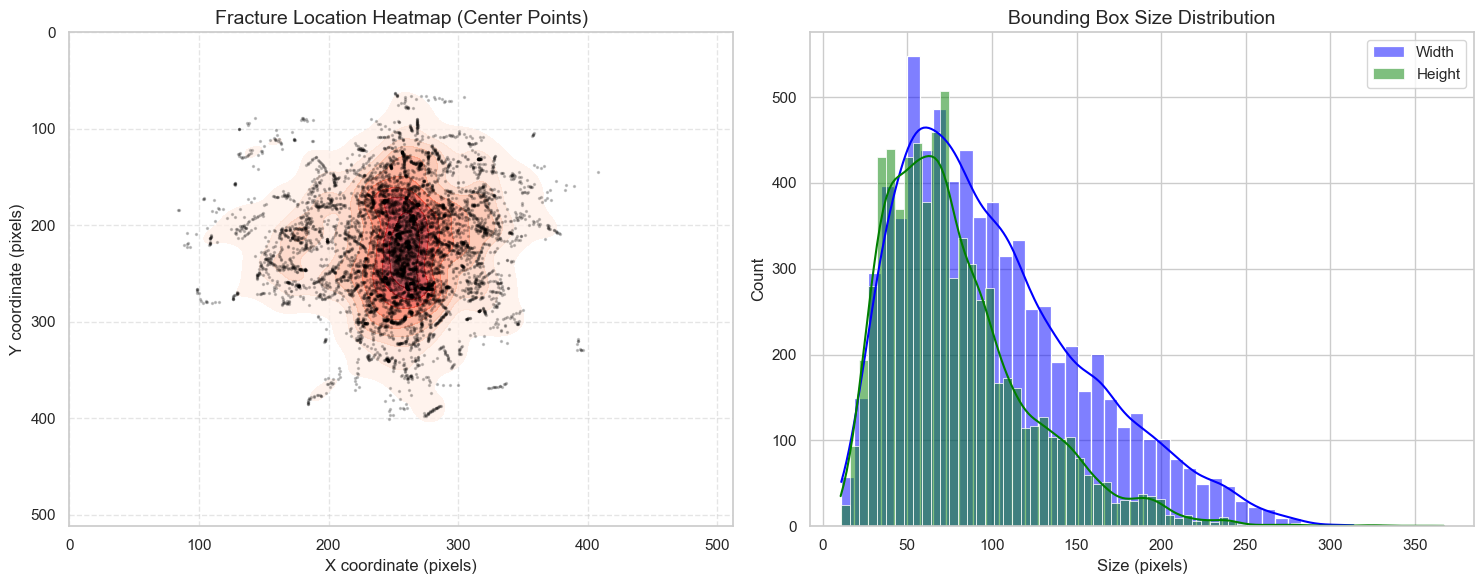

=== Bounding Box Statistics ===
             width       height
count  7217.000000  7217.000000
mean    100.916069    78.787244
std      54.948263    42.884778
min      11.000000    10.632710
25%      57.565400    47.411080
50%      89.307160    70.000000
75%     133.712010    99.000000
max     313.657690   367.029210

평균 박스 비율 (W/H): 1.36


In [28]:
# 중심 좌표 계산
# 박스의 좌측 상단(x, y)과 너비, 높이를 이용해 중심점(center)을 구합니다.
df_bbox['center_x'] = df_bbox['x'] + df_bbox['width'] / 2
df_bbox['center_y'] = df_bbox['y'] + df_bbox['height'] / 2

# 시각화 설정
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# --- [A] 골절 위치 히트맵 (Scatter + KDE) ---
plt.subplot(1, 2, 1)
# 512x512 이미지 규격을 기준으로 그립니다.
plt.title('Fracture Location Heatmap (Center Points)', fontsize=14)
sns.kdeplot(data=df_bbox, x='center_x', y='center_y', fill=True, cmap='Reds', thresh=0.05, alpha=0.7)
plt.scatter(df_bbox['center_x'], df_bbox['center_y'], s=2, alpha=0.2, color='black') # 개별 점 표시

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')
plt.xlim(0, 512)
plt.ylim(512, 0) # CT 이미지 좌표계는 위가 0이므로 Y축을 반전시킵니다.
plt.grid(True, linestyle='--', alpha=0.5)

# --- [B] 박스 크기(Width & Height) 분포 ---
plt.subplot(1, 2, 2)
plt.title('Bounding Box Size Distribution', fontsize=14)
sns.histplot(df_bbox['width'], color='blue', label='Width', kde=True, alpha=0.5)
sns.histplot(df_bbox['height'], color='green', label='Height', kde=True, alpha=0.5)

plt.xlabel('Size (pixels)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# 3. 주요 통계치 출력
print("=== Bounding Box Statistics ===")
print(df_bbox[['width', 'height']].describe())

# 박스 비율(Aspect Ratio) 분석
df_bbox['aspect_ratio'] = df_bbox['width'] / df_bbox['height']
print(f"\n평균 박스 비율 (W/H): {df_bbox['aspect_ratio'].mean():.2f}")

## Pixel spacing, Slice thikness 분석

🧐 [SEG (87)] 그룹 (87명) 메타데이터 추출 중...


100%|██████████| 87/87 [00:00<00:00, 158.79it/s]


🧐 [DET (235)] 그룹 (235명) 메타데이터 추출 중...


100%|██████████| 235/235 [00:01<00:00, 210.78it/s]


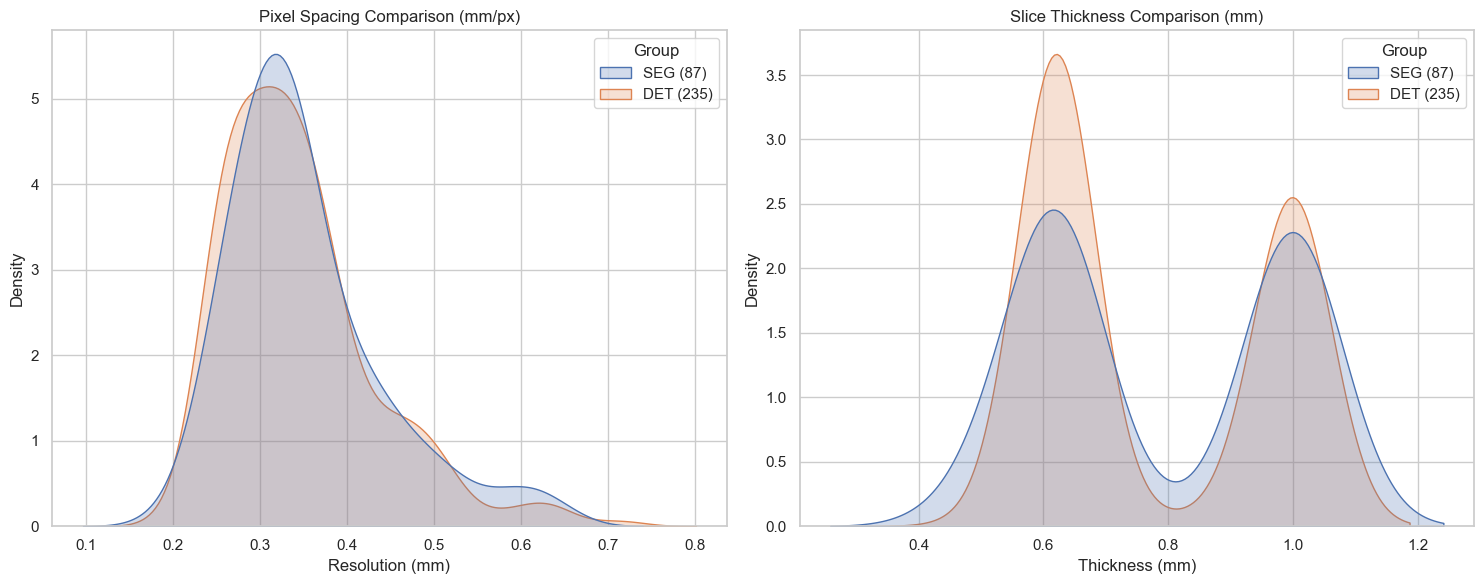


=== 그룹별 메타데이터 요약 ===
Group                  DET (235)   SEG (87)
PixelSpacing   count  235.000000  87.000000
               mean     0.343862   0.351604
               std      0.087161   0.088499
               min      0.201172   0.205078
               25%      0.281250   0.293945
               50%      0.332031   0.332031
               75%      0.379000   0.389648
               max      0.713000   0.630859
SliceThickness count  235.000000  87.000000
               mean     0.775057   0.791092
               std      0.185977   0.196591
               min      0.488281   0.500000
               25%      0.625000   0.625000
               50%      0.625000   0.625000
               75%      1.000000   1.000000
               max      1.000000   1.000000


In [32]:
def get_patient_groups():
    """분석할 두 그룹의 환자 ID 리스트를 가져옵니다."""
    # Group A: 87명의 Segmentation 보유자
    seg_files = [f for f in os.listdir(SEG_DIR) if f.endswith('.nii') or f.endswith('.nii.gz')]
    seg_ids = [f.replace('.nii.gz', '').replace('.nii', '') for f in seg_files]
    
    # Group B: 235명의 Bounding Box 보유자
    bbox_df = pd.read_csv(BBOX_CSV)
    bbox_ids = bbox_df['StudyInstanceUID'].unique().tolist()
    
    return seg_ids, bbox_ids

def analyze_dicom_metadata_by_group(image_dir, patient_ids, group_name):
    metadata_list = []
    print(f"🧐 [{group_name}] 그룹 ({len(patient_ids)}명) 메타데이터 추출 중...")

    for pid in tqdm(patient_ids):
        patient_path = os.path.join(image_dir, pid)
        if not os.path.exists(patient_path): continue
        
        dcm_files = [f for f in os.listdir(patient_path) if f.endswith('.dcm')]
        if not dcm_files: continue
        
        # 첫 번째 파일로 메타데이터 샘플링
        dcm_path = os.path.join(patient_path, dcm_files[0])
        try:
            ds = pydicom.dcmread(dcm_path, stop_before_pixels=True)
            spacing = ds.get("PixelSpacing", [None, None])
            thickness = ds.get("SliceThickness", None)
            
            metadata_list.append({
                'PatientID': pid,
                'Group': group_name,
                'PixelSpacing': float(spacing[0]) if spacing[0] else None,
                'SliceThickness': float(thickness) if thickness else None
            })
        except:
            continue
            
    return pd.DataFrame(metadata_list)

# --- 메인 실행부 ---
seg_ids, bbox_ids = get_patient_groups()

# 두 그룹 데이터 추출
df_seg = analyze_dicom_metadata_by_group(IMAGE_DIR, seg_ids, 'SEG (87)')
df_bbox = analyze_dicom_metadata_by_group(IMAGE_DIR, bbox_ids, 'DET (235)')

# 데이터 합치기
df_total = pd.concat([df_seg, df_bbox], axis=0)

if not df_total.empty:
    # 2. 시각화 (두 그룹 비교)
    plt.figure(figsize=(15, 6))
    
    # [A] Pixel Spacing 비교
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=df_total, x='PixelSpacing', hue='Group', fill=True, common_norm=False)
    plt.title('Pixel Spacing Comparison (mm/px)')
    plt.xlabel('Resolution (mm)')

    # [B] Slice Thickness 비교
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_total, x='SliceThickness', hue='Group', fill=True, common_norm=False)
    plt.title('Slice Thickness Comparison (mm)')
    plt.xlabel('Thickness (mm)')

    plt.tight_layout()
    plt.show()
    
    # 통계 요약
    print("\n=== 그룹별 메타데이터 요약 ===")
    summary = df_total.groupby('Group')[['PixelSpacing', 'SliceThickness']].describe().T
    print(summary)

## C1~7 위치 분포(뼈지도)

🧐 87명의 마스크 데이터를 분석합니다.


100%|██████████| 87/87 [00:59<00:00,  1.46it/s]
C:\Users\smc\AppData\Local\Temp\ipykernel_20012\4276623135.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_atlas, x='Bone', y='Mid_Pct', palette='coolwarm')


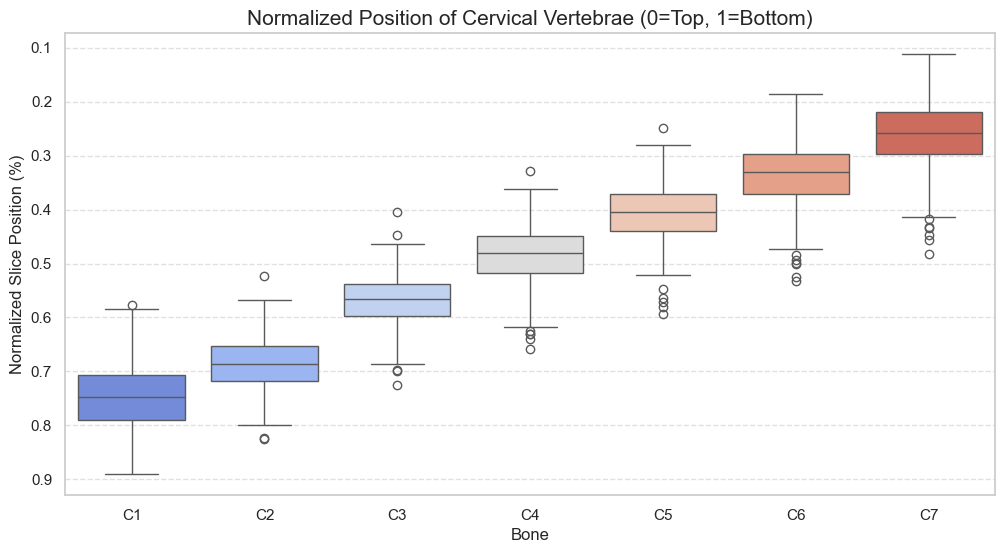


=== 표준 경추 위치 사전 (Atlas Summary) ===
     Start_Pct             End_Pct          
          mean       std      mean       std
Bone                                        
C1    0.651146  0.127987  0.829725  0.070250
C2    0.561648  0.096111  0.829883  0.085975
C3    0.500529  0.062813  0.667478  0.110695
C4    0.420054  0.067690  0.574535  0.097713
C5    0.336829  0.080306  0.491449  0.084384
C6    0.264864  0.086018  0.429721  0.111220
C7    0.184089  0.088462  0.367795  0.121884


In [ ]:
def build_cervical_atlas(seg_dir):
    atlas_data = []
    
    # 세그멘테이션 파일 목록 (87명)
    seg_files = [f for f in os.listdir(seg_dir) if f.endswith('.nii.gz') or f.endswith('.nii')]
    print(f"🧐 {len(seg_files)}명의 마스크 데이터를 분석합니다.")

    for file in tqdm(seg_files):
        patient_id = file.replace('.nii.gz', '').replace('.nii', '')
        
        # NIfTI 파일 로드
        seg_path = os.path.join(seg_dir, file)
        seg_img = nib.load(seg_path)
        mask = seg_img.get_fdata() # (W, H, Slices)
        
        total_slices = mask.shape[2]
        
        # 각 마디(1~7)별 위치 추출
        # mask 데이터의 값은 C1=1, C2=2 ... C7=7로 되어 있음
        for bone_id in range(1, 8):
            # 해당 bone_id가 존재하는 슬라이스 인덱스들 찾기
            # 축 방향(axis=2)으로 합산하여 라벨이 존재하는 층 확인
            bone_mask = np.any(mask == bone_id, axis=(0, 1))
            slice_indices = np.where(bone_mask)[0]
            
            if len(slice_indices) > 0:
                # 위치 정규화: (현재 슬라이스 번호 / 전체 슬라이스 수)
                # 보통 DICOM은 머리(Superior)에서 아래로 번호가 증가하므로 
                # 0에 가까울수록 머리 쪽입니다.
                start_pct = slice_indices.min() / total_slices
                end_pct = slice_indices.max() / total_slices
                mid_pct = np.mean(slice_indices) / total_slices
                
                atlas_data.append({
                    'PatientID': patient_id,
                    'Bone': f'C{bone_id}',
                    'Start_Pct': start_pct,
                    'End_Pct': end_pct,
                    'Mid_Pct': mid_pct
                })

    return pd.DataFrame(atlas_data)

# 실행
df_atlas = build_cervical_atlas(SEG_DIR)

# 2. 결과 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_atlas, x='Bone', y='Mid_Pct', palette='coolwarm')
plt.title('Normalized Position of Cervical Vertebrae (0=Top, 1=Bottom)', fontsize=15)
plt.ylabel('Normalized Slice Position (%)')
plt.gca().invert_yaxis() # 0(머리)이 위로 오도록 축 반전
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 3. 통계 요약 (이것이 "사전" 역할을 합니다)
atlas_summary = df_atlas.groupby('Bone')[['Start_Pct', 'End_Pct']].agg(['mean', 'std'])
print("\n=== 표준 경추 위치 사전 (Atlas Summary) ===")
print(atlas_summary)

In [ ]:
# 아까 구한 atlas_summary의 평균값을 기준으로 범위를 설정했다고 가정
cervical_atlas = {
    'C1': (0.00, 0.12),
    'C2': (0.12, 0.28),
    'C3': (0.28, 0.42),
    'C4': (0.42, 0.55),
    'C5': (0.55, 0.68),
    'C6': (0.68, 0.82),
    'C7': (0.82, 1.00)
}

def predict_bone_id(slice_num, total_slices):
    """상대적 위치를 계산하여 뼈 번호를 예측합니다."""
    rel_pos = slice_num / total_slices
    
    for bone, (start, end) in cervical_atlas.items():
        if start <= rel_pos < end:
            return bone
    return 'C7' # 범위를 벗어나면 마지막 마디로 간주

# 활용 예시: 300장 중 45번 슬라이스는?
print(f"예측 결과: {predict_bone_id(45, 300)}") # 결과: C2 (15% 지점)

예측 결과: C2
